In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import plotly.express as px
from scipy.stats import shapiro, probplot
import pylab
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima, autocorr_plot, ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go

---

# Read data

In [3]:
nintendo = pd.read_csv("../data/NTDOY-months.csv")
nintendo

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-31 00:00:00+00:00,3.388952,3.410762,3.357143,3.376952,3.376952,1.008429e+06
1,2014-02-28 00:00:00+00:00,2.975684,2.996316,2.963368,2.985579,2.985579,9.192632e+05
2,2014-03-31 00:00:00+00:00,2.952762,2.971143,2.941048,2.953143,2.953143,6.412381e+05
3,2014-04-30 00:00:00+00:00,2.748571,2.756190,2.730095,2.739905,2.739905,5.715476e+05
4,2014-05-31 00:00:00+00:00,2.732571,2.749524,2.720190,2.735048,2.735048,6.443095e+05
...,...,...,...,...,...,...,...
126,2024-07-31 00:00:00+00:00,13.701364,13.799546,13.620000,13.695909,13.695909,6.916227e+05
127,2024-08-31 00:00:00+00:00,13.338182,13.520455,13.232727,13.376818,13.376818,9.289773e+05
128,2024-09-30 00:00:00+00:00,13.446000,13.539000,13.319500,13.417500,13.417500,4.408050e+05
129,2024-10-31 00:00:00+00:00,13.261739,13.376522,13.130435,13.272609,13.272609,8.130043e+05


In [4]:
df = nintendo[["Date", "Adj Close"]]
df.set_index("Date", inplace=True)

In [5]:
px.line(data_frame=df, x=df.index, y=df["Adj Close"])

---

# Stationary check

In [6]:
def adf_test(series):
    res = adfuller(series, maxlag=int((len(df)-1)**(1/3)))
    return {
        "Statistic":res[0],
        "p-value":res[1],
    }

### Check for stationary in log original dataset
- H0: Non stationary | H1: Stationary
<br/> p-value > 0.05 => H0 Correct

In [7]:
log_df = np.log(df["Adj Close"])

In [8]:
temp = px.line(data_frame=df, x=df.index, y=log_df)
temp

In [9]:
adf_test(np.log(df["Adj Close"]))

{'Statistic': -1.7151691089782768, 'p-value': 0.4233143291567108}

### Check for stationary in diff log, copy last value of da series to prevent the mismatch data size

In [10]:
difflog = np.diff(np.log(df["Adj Close"]))
difflog = np.append(difflog, difflog[-1])

In [11]:
adf_test(difflog)

{'Statistic': -9.225927952474724, 'p-value': 1.7292971988837455e-15}

In [12]:
temp = px.line(data_frame=difflog, x=df.index, y=difflog)
temp

---

# Check for normality

In [13]:
def shapiro_test(series):
    res = shapiro(series)
    return {
        "statistic":res[0],
        "p-value":res[1]
    }

In [14]:
shapiro_test(difflog)

{'statistic': 0.9356627464294434, 'p-value': 9.730611054692417e-06}

- compare diff df to norm dist

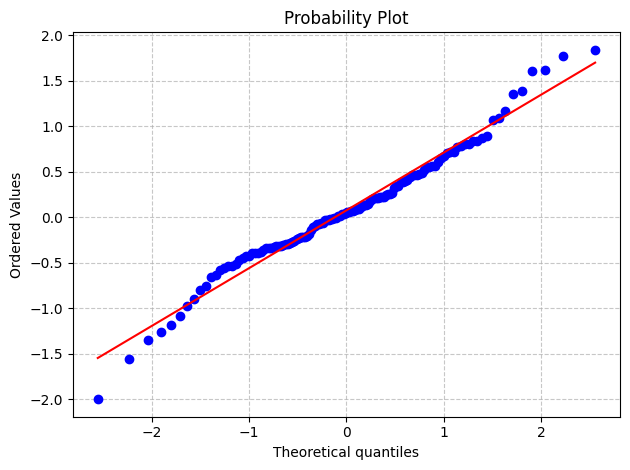

In [41]:
probplot1 = probplot(np.diff(df["Adj Close"]), dist="norm", plot=plt)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

- compare diff log to norm dist

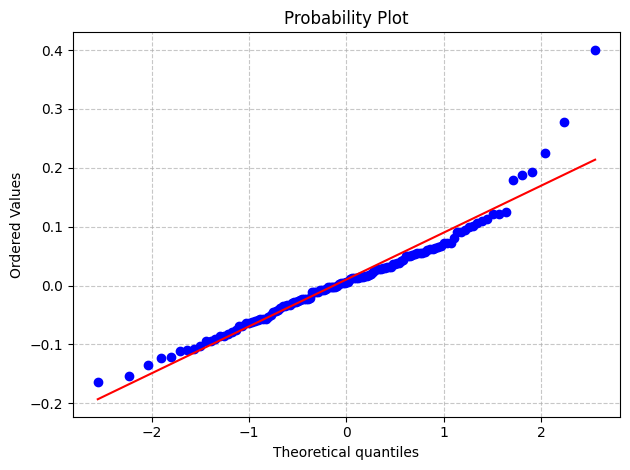

In [38]:
probplot2 = probplot(difflog, dist="norm", plot=plt)

plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

---

# ACF and PACF

In [17]:
def plot_acf2(series):
    fig, axes = plt.subplots(ncols=1, nrows=2)
    plot_acf(series, marker="", ax=axes[0], zero=False)
    plot_pacf(series, marker="", ax=axes[1], zero=False)

    axes[0].grid(True, linestyle="--", alpha=0.7)
    axes[1].grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

    

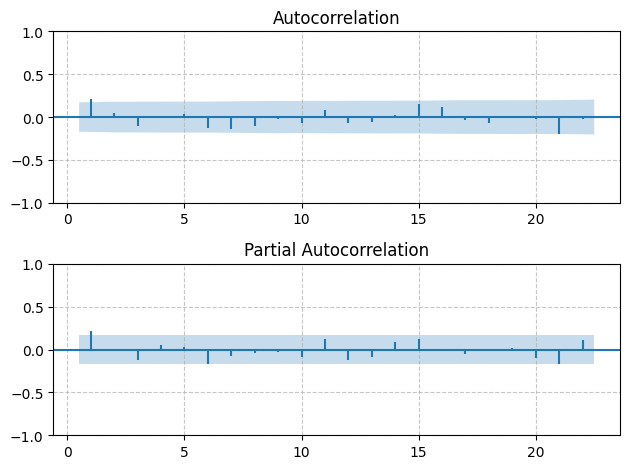

In [18]:
plot_acf2(difflog)

---

# Models

### Train test split in time series way

In [19]:
train_size = int(df.shape[0] * 0.955)  # Use 80% of data for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

log_train = np.log(train["Adj Close"])
diff_log_train = np.diff(np.log(train["Adj Close"]))
diff_log_train = np.append(diff_log_train, diff_log_train[-1])

### AR, MA, ARMA, ARIMA

- Auto Arima for log original data

In [20]:
arima1 = auto_arima(log_train, seasonal=False)
arima1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 139.997
Date:                Sun, 17 Nov 2024   AIC                           -269.993
Time:                        17:34:05   BIC                           -255.892
Sample:                    01-31-2014   HQIC                          -264.265
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.086     -2.858      0.004      -0.413      -0.077
ar.L2         -0.7871      0.081     -9.739      0.000      -0.945      -0.629
ma.L1          0.4455      0.051      8.666      0.000       0.345       0.546
ma.L2          0.9623      0.082     11.788      0.000       0.802       1.122
sigma2         0.0060      0.001      9.389      0.000       0.005       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                52.03
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
preds = arima1.predict(n_periods=test.shape[0])
arima1_preds = np.exp(preds)
mean_squared_error(test, arima1_preds)


0.2215490657870541

=> MSE: 0.221

Check if residual is similar to white fucking noise

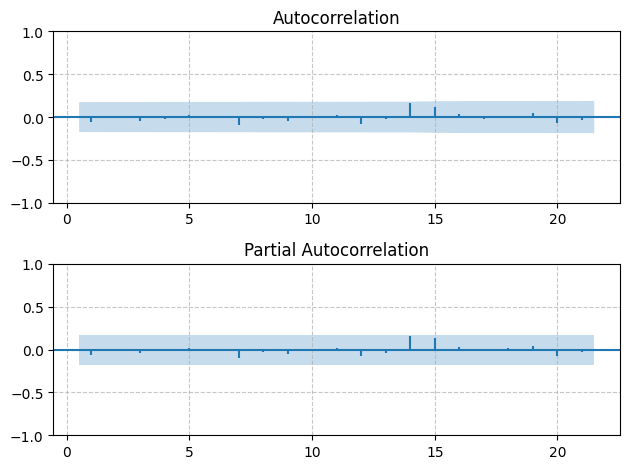

In [22]:
arima1_resid = arima1.resid()
plot_acf2(arima1_resid)

=> No line exceed the fucking blue area => Its white noise => Model is gud

- Auto arima for original data

In [23]:
arima2 = auto_arima(train["Adj Close"], seasonal=False)
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -115.188
Date:                Sun, 17 Nov 2024   AIC                            240.376
Time:                        17:34:08   BIC                            254.477
Sample:                    01-31-2014   HQIC                           246.104
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2423      0.094     -2.566      0.010      -0.427      -0.057
ar.L2         -0.7752      0.093     -8.329      0.000      -0.958      -0.593
ma.L1          0.4375      0.051      8.639      0.000       0.338       0.537
ma.L2          0.9225      0.064     14.527      0.000       0.798       1.047
sigma2         0.3718      0.041      9.077      0.000       0.292       0.452
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 5.84
Prob(Q):                              0.68   Prob(JB):                         0.05
Heteroskedasticity (H):               1.96   Skew:                             0.02
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
arima2_preds = arima2.predict(n_periods=test.shape[0])
mean_squared_error(test, arima2_preds)
# preds

0.1188826943445518

=> MSE: 0.118

Check if residual is similar to white fucking noise

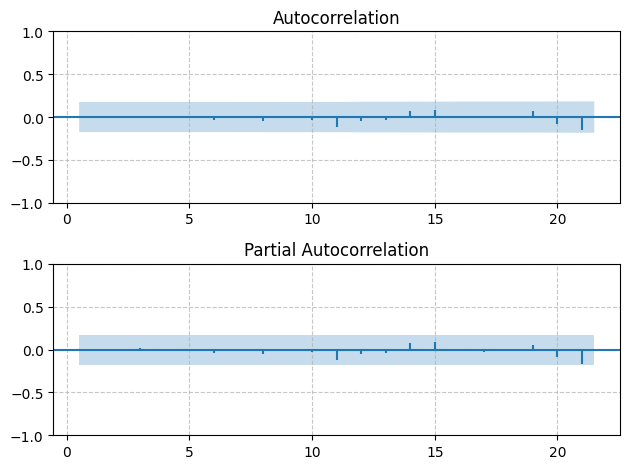

In [25]:
arima2_resid = arima2.resid()
plot_acf2(arima2_resid)

=> No line exceed the fucking blue area => Its white noise => Model is gud

- AR(1)

In [26]:
AR1 = ARIMA(order=(1, 0, 0)).fit(diff_log_train)
AR1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 136.587
Date:                Sun, 17 Nov 2024   AIC                           -267.174
Time:                        17:34:08   BIC                           -258.689
Sample:                             0   HQIC                          -263.727
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0085      0.008      1.020      0.308      -0.008       0.025
ar.L1          0.2138      0.093      2.308      0.021       0.032       0.395
sigma2         0.0066      0.001     11.889      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.33
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
AR1_log_diff_preds = AR1.predict(n_periods=test.shape[0])
AR1_reverted_log_predictions = [np.log(test["Adj Close"]).to_numpy()[-1] + AR1_log_diff_preds[0]]
for i in range(1, len(AR1_log_diff_preds)):
    AR1_reverted_log_predictions.append(AR1_reverted_log_predictions[-1] + AR1_log_diff_preds[i])

AR1_reverted_preds = np.exp(AR1_reverted_log_predictions)
mean_squared_error(test, AR1_reverted_preds)

0.3384950101889983

=> MSE: 0.33

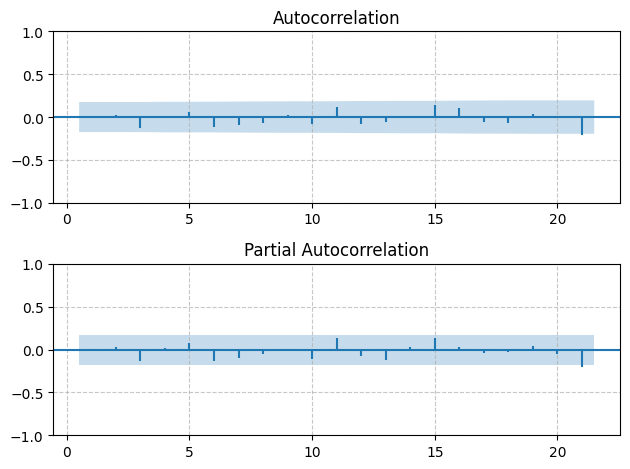

In [28]:
AR1_resid = AR1.resid()
plot_acf2(AR1_resid)

- ARMA(1, 1)

In [29]:
ARMA1 = ARIMA(order=(1, 0, 1)).fit(diff_log_train)
ARMA1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 136.587
Date:                Sun, 17 Nov 2024   AIC                           -265.174
Time:                        17:34:08   BIC                           -253.861
Sample:                             0   HQIC                          -260.578
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0085      0.009      0.956      0.339      -0.009       0.026
ar.L1          0.2166      0.352      0.615      0.539      -0.474       0.907
ma.L1         -0.0029      0.356     -0.008      0.993      -0.701       0.695
sigma2         0.0066      0.001     11.808      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
ARMA1_log_diff_preds = ARMA1.predict(n_periods=test.shape[0])
ARMA1_reverted_log_predictions = [np.log(test["Adj Close"]).to_numpy()[-1] + ARMA1_log_diff_preds[0]]
for i in range(1, len(ARMA1_log_diff_preds)):
    ARMA1_reverted_log_predictions.append(ARMA1_reverted_log_predictions[-1] + ARMA1_log_diff_preds[i])

ARMA1_reverted_preds = np.exp(ARMA1_reverted_log_predictions)
mean_squared_error(test, ARMA1_reverted_preds)

0.3389108811131845

=> MSE: 0.33

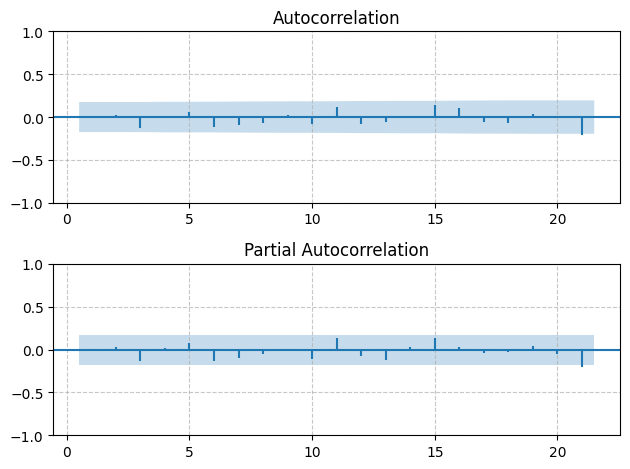

In [31]:
AR1_resid = AR1.resid()
plot_acf2(AR1_resid)

# Forecast

In [32]:
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='M')

In [33]:

trace_riu = go.Scatter(
    x=df.iloc[-18:].index,
    y=df.iloc[-18:]["Adj Close"],
    mode="lines+markers",
    line=dict(color="blue"),
    name="Riu"
)

ARIMA1_forecast = go.Scatter(
    x=forecast_index,
    y=arima1_preds,
    line=dict(color='red', dash='dash'),
    mode="lines+markers",
    marker=dict(symbol='circle', size=4),
    name=f"ARIMA{arima1.order} forecast"
)

ARIMA2_forecast = go.Scatter(
    x=forecast_index,
    y=arima2_preds,
    line=dict(color='green', dash='dash'),
    mode="lines+markers",
    marker=dict(symbol='circle', size=4),
    name=f"ARIMA{arima2.order} forecast"
)

# AR1_forecast = go.Scatter(
#     x=forecast_index,
#     y=AR1_reverted_preds,
#     line=dict(color='green', dash='dash'),
#     mode="lines+markers",
#     marker=dict(symbol='circle', size=4),
#     name=f"AR({AR1.order[0]}) forecast"

# )

ARMA1_forecast = go.Scatter(
    x=forecast_index,
    y=AR1_reverted_preds,
    line=dict(color='purple', dash='dash'),
    mode="lines+markers",
    marker=dict(symbol='circle', size=4),
    name=f"ARMA{ARMA1.order[0] , ARMA1.order[2]} forecast"

)



layout = go.Layout(
    title="Riu vs Forecasted Data",
    xaxis=dict(title="Time"),
    yaxis=dict(title="Value"),
    showlegend=True, 
)



fig = go.Figure(data=[trace_riu, ARIMA1_forecast, ARIMA2_forecast, ARMA1_forecast])
fig.show()